## Recurrent neural networks (RNN) to process long sequences: a temperature-forecasting problem

In the dataset we are going to work with, 14 different quantities (such as air temperature, atmospheric pres-
sure, humidity, wind direction, and so on) were recorded every 10 minutes, over sev-
eral years. The original data goes back to 2003, but this example is limited to data
from 2009–2016. This dataset is perfect for learning to work with numerical
timeseries. You’ll use it to build a model that takes as input some data from the recent
past (a few days’ worth of data points) and predicts the air temperature 24 hours in
the future.

Download and uncompress the data as follows.

In [1]:
import ibm_boto3
from ibm_botocore.client import Config

credentials_ext = {
    'IAM_SERVICE_ID': 'iam-ServiceId-1818c686-ffd1-4a85-ae1c-8b5c44a9ed65',
    'IBM_API_KEY_ID': '-uEu47GQ9zzLPns5ppOz6sZYXkQenFHsI-jzlvmfJbqg',
    'ENDPOINT': 'https://s3.private.eu.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'mieciotwo-donotdelete-pr-ztndj3j7faunm0',
    'FILE': 'jena_climate_2009_2016.csv_v2.zip'
}

cos = ibm_boto3.client('s3',
                       ibm_api_key_id=credentials_ext['IBM_API_KEY_ID'],
                       ibm_service_instance_id=credentials_ext['IAM_SERVICE_ID'],
                       ibm_auth_endpoint=credentials_ext['IBM_AUTH_ENDPOINT'],
                       config=Config(signature_version='oauth'),
                       endpoint_url=credentials_ext['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_ext['BUCKET'], Key=filename)['Body']
    return fileobject

def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

In [2]:
streaming_body = get_file(credentials_ext["FILE"])

In [3]:
from io import BytesIO
import zipfile

zip_ref = zipfile.ZipFile(BytesIO(streaming_body.read()), 'r')
print(zip_ref.namelist())

['jena_climate_2009_2016.csv', '__MACOSX/._jena_climate_2009_2016.csv']


Let’s look at and inspect the data.

In [4]:
#
# Get the data into your notebook memory
#
import io

with io.TextIOWrapper(zip_ref.open('jena_climate_2009_2016.csv'), encoding="utf-8") as f:
    data = f.read()
    
zip_ref.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Now, convert all 420 451 lines of data into a Numpy array.

In [5]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] # We store column 1 in the “temperature” array.
    raw_data[i, :] = values[:] # We store all columns (including the temperature) in the “raw_data” array.

Plotting the temperature timeseries:

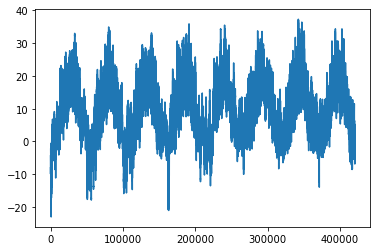

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Plotting the first 10 days of the temperature timeseries

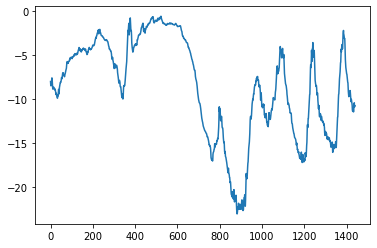

In [7]:
plt.plot(range(1440), temperature[:1440])

### Preparing the data

Let's compute the number of samples we’ll use for each data split

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


... and normalize the data.

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

#### Instantiating datasets for training, validation, and testing

In [10]:
import numpy as np
from tensorflow import keras
#from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)



Inspecting the output of one of our datasets

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Computing the common-sense (i.e. non-machine-learning) baseline MAE 

... here is the evaluation loop in order to compute the common-sense baseline MAE

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # The temperature feature is at column 1, so samples[:, -1, 1] is the last temperature measurement in the
        # input sequence. Recall that we normalized our features, so to retrieve a temperature in degrees Celsius,
        # we need to un-normalize it by multiplying it by the standard deviation and adding back the mean.
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### A basic machine-learning approach

Training and evaluating a densely connected model

In [14]:
EPOCHS = 10

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# We use a callback to save the best performing model.
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",save_best_only=True)
    ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

# Reload the best model and evaluate it on the test data.
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 456s 553ms/step - loss: 11.9203 - mae: 2.6796 - val_loss: 11.8831 - val_mae: 2.7205
Epoch 2/10
819/819 [==============================] - 460s 559ms/step - loss: 9.0581 - mae: 2.3656 - val_loss: 11.5104 - val_mae: 2.6830
Epoch 3/10
819/819 [==============================] - 470s 570ms/step - loss: 8.3312 - mae: 2.2697 - val_loss: 12.7142 - val_mae: 2.8497
Epoch 4/10
819/819 [==============================] - 468s 567ms/step - loss: 7.8706 - mae: 2.2069 - val_loss: 11.7876 - val_mae: 2.6937
Epoch 5/10
819/819 [==============================] - 478s 579ms/step - loss: 7.5079 - mae: 2.1558 - val_loss: 10.6115 - val_mae: 2.5799
Epoch 6/10
819/819 [==============================] - 464s 562ms/step - loss: 7.2302 - mae: 2.1166 - val_loss: 11.8987 - val_mae: 2.7200
Epoch 7/10
819/819 [==============================] - 462s 560ms/step - loss: 7.0292 - mae: 2.0877 - val_loss: 10.7264 - val_mae: 2.5810
Epoch 8/10
819/819 [====================

Let’s display the loss curves for validation and training 

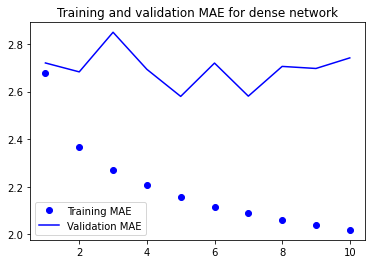

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for dense network")
plt.legend()
plt.show()

### A first recurrent baseline 

Training and evaluating a LSTM-based model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                        save_best_only=True)
    ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                epochs=EPOCHS,
                validation_data=val_dataset,
                callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 845s 1s/step - loss: 44.1893 - mae: 4.8335 - val_loss: 12.9284 - val_mae: 2.7378
Epoch 2/10
819/819 [==============================] - 842s 1s/step - loss: 11.2707 - mae: 2.6124 - val_loss: 9.5770 - val_mae: 2.4152
Epoch 3/10
819/819 [==============================] - 837s 1s/step - loss: 9.8599 - mae: 2.4478 - val_loss: 9.5207 - val_mae: 2.3970
Epoch 4/10
819/819 [==============================] - 920s 1s/step - loss: 9.2718 - mae: 2.3694 - val_loss: 9.4668 - val_mae: 2.3885
Epoch 5/10
819/819 [==============================] - 901s 1s/step - loss: 8.8143 - mae: 2.3101 - val_loss: 9.6277 - val_mae: 2.4108
Epoch 6/10
819/819 [==============================] - 852s 1s/step - loss: 8.4855 - mae: 2.2688 - val_loss: 9.8151 - val_mae: 2.4406
Epoch 7/10
819/819 [==============================] - 837s 1s/step - loss: 8.2065 - mae: 2.2309 - val_loss: 9.8599 - val_mae: 2.4596
Epoch 8/10
819/819 [==============================] - 870s 1s/step

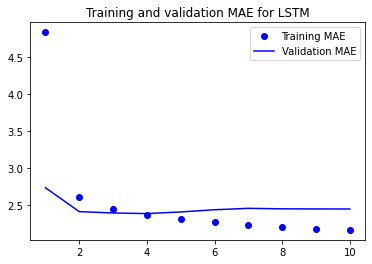

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for LSTM")
plt.legend()
plt.show()

Now we can see the results! Much better! You can significantly beat the common-sense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

### Using recurrent dropout to fight overfitting

Training and evaluating a dropout-regularized LSTM-based model

In [19]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
#To regularize the Dense layer we also add a Dropout layer after the LSTM.
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
        keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                                save_best_only=True)
            ]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 1665s 2s/step - loss: 27.7336 - mae: 3.8835 - val_loss: 9.8467 - val_mae: 2.4437
Epoch 2/10
819/819 [==============================] - 1697s 2s/step - loss: 14.9635 - mae: 3.0036 - val_loss: 9.0938 - val_mae: 2.3496
Epoch 3/10
819/819 [==============================] - 1684s 2s/step - loss: 13.9556 - mae: 2.8969 - val_loss: 9.0040 - val_mae: 2.3359
Epoch 4/10
819/819 [==============================] - 1688s 2s/step - loss: 13.2736 - mae: 2.8233 - val_loss: 9.2387 - val_mae: 2.3702
Epoch 5/10
819/819 [==============================] - 1691s 2s/step - loss: 12.7346 - mae: 2.7654 - val_loss: 9.1998 - val_mae: 2.3636
Epoch 6/10
819/819 [==============================] - 1677s 2s/step - loss: 12.3369 - mae: 2.7249 - val_loss: 9.1494 - val_mae: 2.3621
Epoch 7/10
819/819 [==============================] - 1686s 2s/step - loss: 12.0619 - mae: 2.6944 - val_loss: 9.3214 - val_mae: 2.3725
Epoch 8/10
819/819 [==============================] - 1

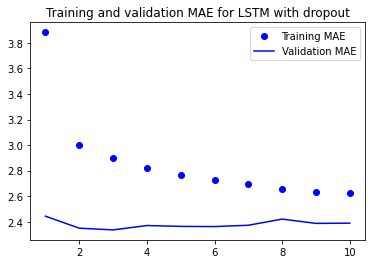

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for LSTM with dropout")
plt.legend()
plt.show()

### Stacking recurrent layers

Training and evaluating a dropout-regularized, stacked GRU model

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
            keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
            save_best_only=True)
            ]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 659s 800ms/step - loss: 25.0567 - mae: 3.7001 - val_loss: 9.5059 - val_mae: 2.3919
Epoch 2/10
819/819 [==============================] - 656s 800ms/step - loss: 13.9937 - mae: 2.8996 - val_loss: 8.8218 - val_mae: 2.3032
Epoch 3/10
819/819 [==============================] - 656s 800ms/step - loss: 13.1856 - mae: 2.8142 - val_loss: 8.7556 - val_mae: 2.2886
Epoch 4/10
819/819 [==============================] - 657s 801ms/step - loss: 12.5506 - mae: 2.7442 - val_loss: 8.7774 - val_mae: 2.2945
Epoch 5/10
819/819 [==============================] - 654s 798ms/step - loss: 12.0642 - mae: 2.6931 - val_loss: 8.9477 - val_mae: 2.3210
Epoch 6/10
819/819 [==============================] - 656s 800ms/step - loss: 11.5642 - mae: 2.6345 - val_loss: 9.2014 - val_mae: 2.3517
Epoch 7/10
819/819 [==============================] - 651s 794ms/step - loss: 11.2187 - mae: 2.5966 - val_loss: 8.8190 - val_mae: 2.3085
Epoch 8/10
819/819 [=====================

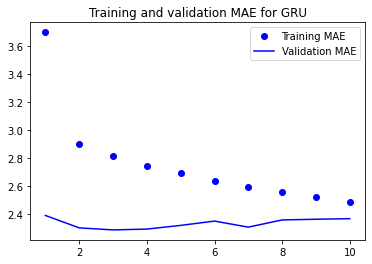

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE for GRU")
plt.legend()
plt.show()

### Using bidirectional RNNs

The last technique introduced in this section is called bidirectional RNN s. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. **It’s frequently used in natural-language processing—you
could call it the Swiss Army knife of deep learning for natural-language processing.** Training the same LSTM-based model that you used in the first experiment in this section, you get the results shown below.

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 330s 400ms/step - loss: 26.3627 - mae: 3.7183 - val_loss: 10.2878 - val_mae: 2.4975
Epoch 2/10
819/819 [==============================] - 329s 401ms/step - loss: 9.6372 - mae: 2.4201 - val_loss: 9.3462 - val_mae: 2.3814
Epoch 3/10
819/819 [==============================] - 312s 380ms/step - loss: 8.6882 - mae: 2.2918 - val_loss: 9.3997 - val_mae: 2.3755
Epoch 4/10
819/819 [==============================] - 320s 390ms/step - loss: 8.1190 - mae: 2.2151 - val_loss: 9.6603 - val_mae: 2.3964
Epoch 5/10
819/819 [==============================] - 352s 429ms/step - loss: 7.6663 - mae: 2.1543 - val_loss: 10.4760 - val_mae: 2.4983
Epoch 6/10
819/819 [==============================] - 381s 464ms/step - loss: 7.3168 - mae: 2.1075 - val_loss: 10.5253 - val_mae: 2.4903
Epoch 7/10
819/819 [==============================] - 320s 390ms/step - loss: 7.0662 - mae: 2.0729 - val_loss: 10.9954 - val_mae: 2.5654
Epoch 8/10
819/819 [=======================

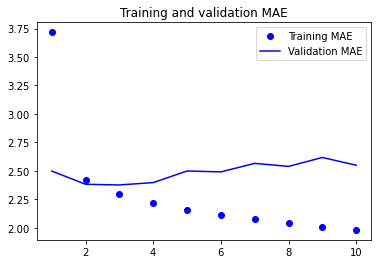

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

The reversed-order GRU strongly underperforms even the common-sense baseline,
indicating that in this case, chronological processing is important to the success of your
approach. This makes perfect sense: the underlying GRU layer will typically be better at
remembering the recent past than the distant past, and naturally the more recent
weather data points are more predictive than older data points for the problem (that’s
what makes the common-sense baseline fairly strong). Let's try this approach on our temperature-prediction task and training a bidirectional GRU.

## Markets and machine learning

Some readers are bound to want to take the techniques we’ve introduced here and
try them on the problem of forecasting the future price of securities on the stock mar-
ket (or currency exchange rates, and so on). Markets have very different statistical
characteristics than natural phenomena such as weather patterns. **Trying to use
machine learning to beat markets, when you only have access to publicly available
data, is a difficult endeavor, and you’re likely to waste your time and resources with
nothing to show for it.**
Always remember that when it comes to markets, past performance is not a good
predictor of future returns—looking in the rear-view mirror is a bad way to drive.
Machine learning, on the other hand, is applicable to datasets where the past is a
good predictor of the future.